In [1]:
import sklearn
import numpy as np

import os
import json

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import pandas as pd
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

## FitBit Sleep Data

In [5]:
sleep_dir = os.walk('Sleep')

In [6]:
sleep_jsons = []
for root, dirs, files in sleep_dir:
    for name in files:
        file = os.path.join(root, name)
        if 'json' in file:
            sleep_jsons.append(os.path.join(root, name)) 
    for name in dirs:
        print(os.path.join(root, name))

In [7]:
sleep_info = []
for j in sleep_jsons:
    f = json.load(open(j,'r'))
    for s in f:
        if s['mainSleep']:
            try:
                date_dict = {}
                for i in s: 
                    if i == 'dateOfSleep':
                        date_dict['date'] = s[i]
                    elif i =='levels':
                        date_dict['deep'] = s[i]['summary']['deep']['minutes']
                        date_dict['wake'] = s[i]['summary']['wake']['minutes']
                        date_dict['light'] = s[i]['summary']['light']['minutes']
                        date_dict['rem'] = s[i]['summary']['rem']['minutes']
                sleep_info.append(date_dict)
            except:
                KeyError

In [8]:
sleep_df = pd.DataFrame(data=sleep_info,columns=['date','deep','wake','light','rem'])

In [9]:
sleep_df['date'] = pd.to_datetime(sleep_df['date'])
sleep_df.sort_values(by='date', inplace=True)
sleep_df['date'] = sleep_df['date'].astype('str')

In [10]:
sleep_df.head()

,date,deep,wake,light,rem
44,2017-12-17,40,69,188,73
43,2017-12-18,53,66,208,115
42,2017-12-19,57,73,208,138
11,2019-07-08,55,83,281,64
10,2019-07-09,57,59,239,38


## Strava Data Time

In [11]:
strava_df = pd.read_csv('./stravadata.csv')

In [12]:
strava_df.drop(columns=['Unnamed: 0'], inplace=True)

In [13]:
strava_df.head()

,average_speed,average_heartrate,average_watts,distance,moving_time,total_elevation_gain,type,start_date_local
0,3.489,180.6,NaN,9930.8,0:47:26,86.0,Run,2020-09-23T18:30:44
1,3.595,170.0,NaN,7746.9,0:35:55,81.0,Run,2020-09-21T17:57:51
2,7.588,150.9,126.4,74781.0,2:44:15,401.0,Ride,2020-09-20T13:24:11
3,3.411,169.6,NaN,11109.6,0:54:17,63.0,Run,2020-09-19T10:17:15
4,8.133,168.2,138.9,34313.0,1:10:19,77.0,Ride,2020-09-17T16:40:09


In [14]:
strava_df = strava_df[strava_df['type'].isin(['Ride','Run'])]

In [15]:
strava_df['average_watts'] = np.where(strava_df['average_watts'].isna(), 0, strava_df['average_watts'])

In [16]:
def convert_str_to_second(time):
    h, m, s = time.split(':')
    h = int(h)
    m = int(m)
    s = int(s)
    totalseconds = (h*3600) + (m*60) + (s)
    return totalseconds

In [17]:
def get_minutes(time_str):
    h, m, s = time_str.split(':') 
    total_min = int(h)*60+int(m)+int(s)/60
    return int(total_min)

In [18]:
strava_df['total_seconds'] = strava_df['moving_time'].apply(lambda x: convert_str_to_second(x))
strava_df['total_minutes'] = strava_df['moving_time'].apply(lambda x: get_minutes(x))

strava_df['distance'] = strava_df['distance']/1609.34
strava_df['average_speed'] = strava_df['average_speed'] * 2.23694
strava_df['average_speed']  = strava_df['average_speed'].round(2)

strava_df['miles/sec'] = strava_df['distance']/strava_df['total_seconds']

strava_df['miles/hr'] = strava_df['miles/sec']*3600

strava_df_hr_data = strava_df[strava_df['average_heartrate'].notnull()]
strava_df_no_hr_data = strava_df[strava_df['average_heartrate'].isna()]

In [19]:
type(strava_df['start_date_local'][0])

str

In [20]:
strava_df['date'] = pd.to_datetime(strava_df['start_date_local']).dt.date
strava_df['date'] = strava_df['date'].astype('str')

In [21]:
strava_df

,average_speed,average_heartrate,average_watts,distance,moving_time,total_elevation_gain,type,start_date_local,total_seconds,total_minutes,miles/sec,miles/hr,date
0,7.80,180.6,0.0,6.170728,0:47:26,86.0,Run,2020-09-23T18:30:44,2846,47,0.002168,7.805559,2020-09-23
1,8.04,170.0,0.0,4.813712,0:35:55,81.0,Run,2020-09-21T17:57:51,2155,35,0.002234,8.041469,2020-09-21
2,16.97,150.9,126.4,46.466875,2:44:15,401.0,Ride,2020-09-20T13:24:11,9855,164,0.004715,16.974201,2020-09-20
3,7.63,169.6,0.0,6.903203,0:54:17,63.0,Run,2020-09-19T10:17:15,3257,54,0.002119,7.630190,2020-09-19
4,18.19,168.2,138.9,21.321163,1:10:19,77.0,Ride,2020-09-17T16:40:09,4219,70,0.005054,18.192981,2020-09-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,13.67,NaN,99.3,28.306200,2:04:13,109.5,Ride,2016-06-27T18:37:46,7453,124,0.003798,13.672658,2016-06-27
353,14.41,NaN,118.9,28.683622,1:59:25,261.8,Ride,2016-06-24T18:25:31,7165,119,0.004003,14.411869,2016-06-24
354,14.68,NaN,115.4,26.068140,1:46:32,226.7,Ride,2016-06-22T05:24:30,6392,106,0.004078,14.681681,2016-06-22
355,13.52,NaN,99.8,18.287310,1:21:08,147.6,Ride,2016-06-21T05:57:06,4868,81,0.003757,13.523894,2016-06-21


In [22]:
strava_df = strava_df.merge(sleep_df, on='date', how='right')

In [23]:
strava_df.sort_values(by='date', inplace=True)

In [24]:
strava_df

,average_speed,average_heartrate,average_watts,distance,moving_time,total_elevation_gain,type,start_date_local,total_seconds,total_minutes,miles/sec,miles/hr,date,deep,wake,light,rem
223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-17,40,69,188,73
224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-18,53,66,208,115
225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-19,57,73,208,138
222,13.79,NaN,116.8,8.793481,0:38:16,200.5,Ride,2019-07-08T18:32:20,2296.0,38.0,0.003830,13.787687,2019-07-08,55,83,281,64
226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-09,57,59,239,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,5.38,NaN,0.0,7.880125,1:27:48,544.9,Run,2020-08-19T17:06:21,5268.0,87.0,0.001496,5.385051,2020-08-19,68,92,247,98
3,8.35,NaN,0.0,2.939031,0:21:07,42.4,Run,2020-08-20T17:02:36,1267.0,21.0,0.002320,8.350838,2020-08-20,88,65,275,80
2,7.84,NaN,161.1,4.701493,0:35:59,479.0,Ride,2020-08-21T16:47:24,2159.0,35.0,0.002178,7.839450,2020-08-21,70,85,279,75
1,25.31,NaN,56.5,4.647122,0:11:01,14.7,Ride,2020-08-21T18:38:38,661.0,11.0,0.007030,25.309593,2020-08-21,70,85,279,75


In [25]:
strava_df['deep_avg'] = strava_df['deep'].rolling(window=7).mean()
strava_df['rem_avg'] = strava_df['rem'].rolling(window=7).mean()
strava_df['wake_avg'] = strava_df['wake'].rolling(window=7).mean()
strava_df['light_avg'] = strava_df['light'].rolling(window=7).mean()

In [26]:
strava_df['type']

223     NaN
224     NaN
225     NaN
222    Ride
226     NaN
       ... 
4       Run
3       Run
2      Ride
1      Ride
0       Run
Name: type, Length: 407, dtype: object

In [27]:
strava_df['minutes_running'] = np.where(strava_df['type']=='Run',strava_df['total_minutes'],0)
strava_df['minutes_cycling'] = np.where(strava_df['type']=='Ride',strava_df['total_minutes'],0)

In [28]:
strava_df['running_toll'] = strava_df['minutes_running'].rolling(window=7).sum()
strava_df['cycling_toll'] = strava_df['minutes_cycling'].rolling(window=7).sum()

In [29]:
strava_df.drop(columns=['average_heartrate'],inplace=True)

In [30]:
strava_df.dropna(inplace=True)

In [31]:
strava_df_run = strava_df[strava_df['type']=='Run']

In [32]:
strava_df_run['prev_pace'] = strava_df['miles/hr'].shift(1)

In [34]:
strava_df_run.drop(columns=['average_watts', 'minutes_cycling'],inplace=True)

In [35]:
strava_df_run.columns

Index(['average_speed', 'distance', 'moving_time', 'total_elevation_gain',
       'type', 'start_date_local', 'total_seconds', 'total_minutes',
       'miles/sec', 'miles/hr', 'date', 'deep', 'wake', 'light', 'rem',
       'deep_avg', 'rem_avg', 'wake_avg', 'light_avg', 'minutes_running',
       'running_toll', 'cycling_toll', 'prev_pace'],
      dtype='object')

In [36]:
strava_df_run['cycling_toll'].value_counts()

0.0      160
175.0      4
47.0       4
44.0       4
166.0      4
388.0      3
37.0       3
84.0       2
393.0      2
113.0      2
216.0      1
177.0      1
121.0      1
199.0      1
297.0      1
282.0      1
240.0      1
336.0      1
Name: cycling_toll, dtype: int64

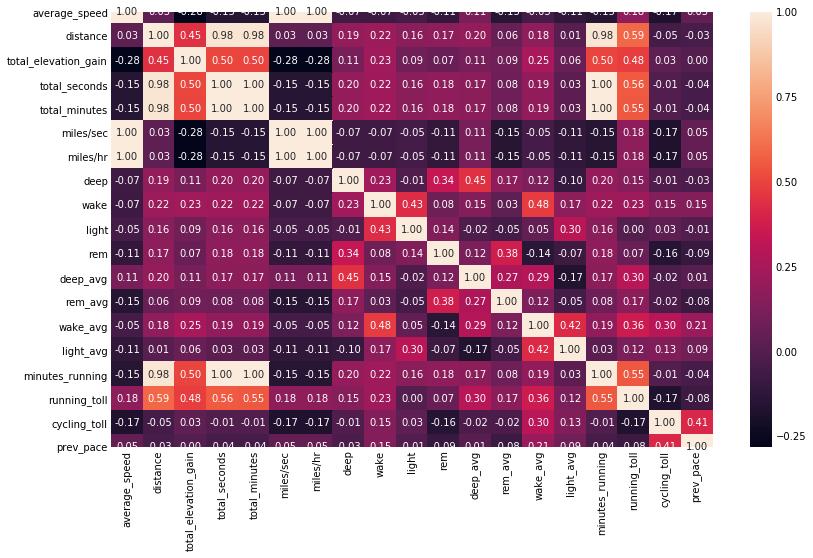

In [37]:
corr = strava_df_run.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, annot=True, fmt=".2f")

In [38]:
y = strava_df_run[['miles/hr']]

In [39]:
X = strava_df_run[['distance','total_elevation_gain','total_elevation_gain','running_toll', 'cycling_toll', 
                  'deep', 'wake','light', 'rem', 'deep_avg', 'rem_avg', 'wake_avg', 'light_avg']]

In [40]:
len(X)

196

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=150, test_size=46, random_state=4)

In [42]:
max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=max_depth,
                                                          random_state=0))

In [43]:
regr_multirf.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     oob_score=False,
                                                   

In [44]:
regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth,
                                random_state=2)
regr_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=2, verbose=0,
                      warm_start=False)

In [45]:
y_multirf = regr_multirf.predict(X_test)
y_rf = regr_rf.predict(X_test)

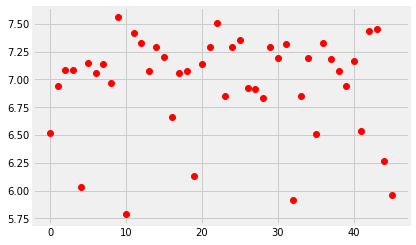

In [46]:
plt.plot(y_multirf, 'ro')

In [47]:
y_test_arr = np.array(y_test['miles/hr'])

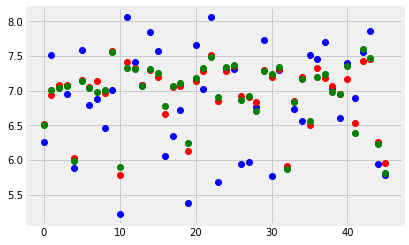

In [48]:
plt.figure()
plt.plot(y_test_arr, 'bo')
plt.plot(y_multirf, 'ro')
plt.plot(y_rf,'go')

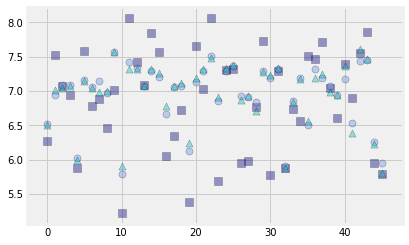

In [54]:
s = 50
a = 0.4
plt.scatter(y=y_test_arr, x=range(0,len(y_test_arr)), edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y=y_multirf,x=range(0,len(y_test_arr)), edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, y_test))
plt.scatter(y=y_rf,x=range(0,len(y_test_arr)), edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(X_test, y_test))

In [60]:
y_test.plot(kind='scatter', x=y_test.index, y=y_test['miles/hr'])

KeyError: "None of [Int64Index([202,  68, 178,  34, 214, 143,  57,   7, 164,  23,  19,  60, 111,\n            151, 119,  18, 130,  20, 141,   4, 123, 129,  55, 179, 124, 103,\n            209, 199,  91,  21, 194,  56,  27,  36,  38, 113, 101, 110,  92,\n            186, 132,  29,  99, 107, 165, 166],\n           dtype='int64')] are in the [columns]"

In [59]:
plt.figure()
s = 50
a = 0.4
plt.scatter(y_test['miles/hr'], edgecolor='k', c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_multirf, edgecolor='k', c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, y_test))
plt.scatter(y_rf, edgecolor='k',c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(X_test, y_test))

TypeError: scatter() missing 1 required positional argument: 'y'

<Figure size 432x288 with 0 Axes>

In [78]:
strava_df_hr_data = strava_df[strava_df['average_heartrate'].notnull()]
strava_df_no_hr_data = strava_df[strava_df['average_heartrate'].isna()]

KeyError: 'average_heartrate'

In [ ]:
strava_df_no_hr_data

In [ ]:
sns.countplot(strava_df['type'])
plt.title('Types of activities')

In [ ]:
sns.pairplot(strava_df, hue='type')

In [ ]:
corr = strava_df.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, annot=True, fmt=".2f")

In [ ]:
trends = strava_df.copy()

In [ ]:
trends

In [ ]:
trends.set_index(pd.to_datetime(trends.start_date_local), drop=True, inplace=True)

In [ ]:
trends

In [ ]:
trends['weekday'] = trends.index.map(lambda x: x.weekday)

In [ ]:
trends.groupby('weekday').mean()

In [ ]:
trends.groupby('weekday').mean()['total_minutes'].plot(kind='bar')

In [ ]:
import calendar
list(calendar.day_name)

In [ ]:
trends.groupby('weekday').mean()['total_minutes'].plot(kind='bar', figsize=(12,5));
plt.xticks(list(range(7)), list(calendar.day_name), rotation='horizontal');
plt.xlabel('')
plt.ylabel('Time in minutes')
plt.title('Average training time by day of the week')

In [ ]:
trends['year'] = trends.index.map(lambda x: x.year)

In [ ]:
grouped = trends.groupby(['year', 'type']).mean()
grouped

In [ ]:
grouped['total_minutes'].plot(kind='bar');

In [ ]:
grouped['total_minutes'].unstack('type')

In [ ]:
result = grouped['total_minutes'].unstack('type').fillna(0)

In [ ]:
result.plot(kind='bar', stacked=True)
plt.title('Yearly average for cycling and running');

In [ ]:
strava_df = strava_df[strava_df['type']=="Ride"]
strava_df.drop(['type'], axis=1, inplace=True)
strava_df.head()

In [ ]:
cols = ['average_watts', 'distance', 'total_elevation_gain','total_minutes' ]
sns.pairplot(x_vars=cols, y_vars=cols, data=strava_df, size=5);

In [ ]:
import sklearn
from sklearn.preprocessing import StandardScaler
strava_df = strava_df[cols]
X = StandardScaler().fit_transform(strava_df)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import 
model = KMeans(n_clusters=4)
model.fit(X)
strava_df['Cluster'] = model.labels_

In [ ]:
sns.pairplot(x_vars=cols, y_vars=cols, hue='Cluster', data=strava_df);

In [ ]:
strava_df.groupby('Cluster').mean()

In [ ]:
strava_df.groupby('Cluster').std()

In [ ]:
sleep_dir = os.walk('Sleep')

In [ ]:
sleep_jsons = []
for root, dirs, files in sleep_dir:
    for name in files:
        file = os.path.join(root, name)
        if 'json' in file:
            sleep_jsons.append(os.path.join(root, name)) 
    for name in dirs:
        print(os.path.join(root, name))

In [ ]:
sleep_info = []
for j in sleep_jsons:
    f = json.load(open(j,'r'))
    for s in f:
        if s['mainSleep']:
            try:
                date_dict = {}
                for i in s: 
                    if i == 'dateOfSleep':
                        date_dict['date'] = s[i]
                    elif i =='levels':
                        date_dict['deep'] = s[i]['summary']['deep']['minutes']
                        date_dict['wake'] = s[i]['summary']['wake']['minutes']
                        date_dict['light'] = s[i]['summary']['light']['minutes']
                        date_dict['rem'] = s[i]['summary']['rem']['minutes']
                sleep_info.append(date_dict)
            except:
                KeyError

In [ ]:
# sleep_df = pd.DataFrame(data=date_dict,columns=['date','deep','wake','light','rem'], axis=1)
sleep_df = pd.DataFrame(data=sleep_info,columns=['date','deep','wake','light','rem']) 

In [ ]:
sleep_df['date'] = pd.to_datetime(sleep_df['date'])

In [ ]:
sleep_df.sort_values(by='date', inplace=True)

In [ ]:
sleep_df['date'] = sleep_df['date'].astype('str')

In [ ]:
sleep_df